In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy import linalg as LA

#from model_prediction import RE
#from model_prediction import Replicator
from pneumococcus_data import data_observation
from Jacobian import jacobian_func
from compute_dynamics import *

In [3]:
# import Particle Swarm Optimization algorithm
from PSO_algo import Particle
from PSO_algo import PSO

### Description
The number of serotypes reported in Iran is $30$; and $\mu = 0.93$. \
We need to estimate the matrix $30 \times 30$ $\left(\alpha_{ij}\right)$ of Iran. Since $\mu$ of Iran is not large, we estimate parameters such that the data observation (Iran prevalence) is the stable equilibrium of the replicator dynamics. Our process are described as follows: \
i) From $\alpha_{ij}$'s estimated from previous epidemiological sites, in Iran's $\alpha_{ij}$ matrix, we insert $331$ values of common $\alpha_{ij}$'s. \
ii) Then we calculate $\Lambda$ matrix and use PSO algorithm in range $\left[-10, 10\right]$ to estimate $569$ remaining $\alpha_{ij}$'s such that data observation $z^*$ satisfies: $\left\|\Lambda z^* - {z^*}^T\Lambda z^*\right\|_2$ attains its minimum. \
In PSO algorithm, we choose the range $\left[-10,10\right]$ for these $569$ $\alpha_{ij}$'s.

In [4]:
# data observation from 5 countries
Iran, Denmark, Brazil, Nepal, Mozambique = data_observation()

# import name of serotypes and their frequencies from Iran
Iran_strain = np.array(Iran.strain)
Iran_cases = np.array(Iran.cases)
strain_number = len(Iran_strain) # = 30

#ratio of single to co-colonization prevalence: mu value of Iran
mu = 0.93

#import Nepal alpha & data
Nepal_alpha = np.loadtxt(open("Nepal_alpha.txt","rb"), delimiter = ",", skiprows = 0)
Nepal_strain = np.array(Nepal.strain)


#import Brazil alpha & data
Brazil_alpha = np.loadtxt(open("Brazil_alpha.txt","rb"), delimiter = ",", skiprows = 0)
Brazil_strain = np.array(Brazil.strain)

#import Denmark alpha & data
Denmark_alpha = np.loadtxt(open("Denmark_alpha.txt","rb"), delimiter = ",", skiprows = 0)
Denmark_strain = np.array(Denmark.strain)

#import Mozambique alpha & data
Mozambique_alpha = np.loadtxt(open("Mozambique_alpha.txt","rb"), delimiter = ",", skiprows = 0)
Mozambique_strain = np.array(Mozambique.strain)

In [5]:
# initiate matrix Mozambique_alpha
Iran_alpha = np.ones((strain_number, strain_number))*50

#In Iran alpha matrix, find the positions of alpha_ij already estimated before in Nepal, Brazil, Denmark, Mozambique and fills with these values
for xI, strain_xI in enumerate(Iran_strain):
    for yI, strain_yI in enumerate(Iran_strain):
        #insert from Nepal
        find_xNepal = np.where(Nepal_strain == strain_xI)
        index_xNepal = find_xNepal[0]

        find_yNepal = np.where(Nepal_strain == strain_yI)
        index_yNepal = find_yNepal[0]

        #insert from Brazil
        find_xBrazil = np.where(Brazil_strain == strain_xI)
        index_xBrazil = find_xBrazil[0]

        find_yBrazil = np.where(Brazil_strain == strain_yI)
        index_yBrazil = find_yBrazil[0]

        #insert from Denmark
        find_xDenmark = np.where(Denmark_strain == strain_xI)
        index_xDenmark = find_xDenmark[0]

        find_yDenmark = np.where(Denmark_strain == strain_yI)
        index_yDenmark = find_yDenmark[0]

        #insert from Mozambique
        find_xMozambique = np.where(Mozambique_strain == strain_xI)
        index_xMozambique = find_xMozambique[0]

        find_yMozambique = np.where(Mozambique_strain == strain_yI)
        index_yMozambique = find_yMozambique[0]

        if index_xNepal.size > 0 and index_yNepal.size > 0:
            Iran_alpha[xI, yI] = Nepal_alpha[index_xNepal, index_yNepal]
        elif index_xBrazil.size > 0 and index_yBrazil.size > 0:
            Iran_alpha[xI, yI] = Brazil_alpha[index_xBrazil, index_yBrazil]
        elif index_xDenmark.size > 0 and index_yDenmark.size > 0:
            Iran_alpha[xI, yI] = Denmark_alpha[index_xDenmark, index_yDenmark]
        elif index_xMozambique.size > 0 and index_yMozambique.size > 0:
            Iran_alpha[xI, yI] = Mozambique_alpha[index_xMozambique, index_yMozambique]

#np.savetxt('fix_alpha_Iran.txt', Iran_alpha, delimiter = ',')

In [6]:
#find the length of vector that we need to fit the matrix Iran alpha
length = 0

for i in range(0, strain_number):
    for j in range(0, strain_number):
        if Iran_alpha[i,j] > 49:
            length += 1

print(length)
#so we need to fit the matrix Iran

569


In [8]:
#find the coordinate of missing alpha_ij in Iran alpha_matrix
position = []

for i in range (0, strain_number):
    for j in range (0, strain_number):
        if Iran_alpha[i,j] > 49:
            position.append(np.array([i,j]))

In [11]:
#cost function for PSO
one = np.ones(strain_number) #vector of all ones

def func(vector):
    # insert alpha vector to Iran_alpha
    alpha_matrix = np.loadtxt(open("fix_alpha_Iran.txt","rb"), delimiter = ",", skiprows = 0)
    
    for i in range (0, length):
        coordinate = position[i]
        alpha_matrix[coordinate[0], coordinate[1]] = vector[i]
        
    #compute invasion fitness matrix
    lambd = np.zeros((strain_number, strain_number))
    for i in range (0, strain_number):
        for j in range (0, strain_number):
            lambd[i][j] = mu*(alpha_matrix[j][i] - alpha_matrix[i][j]) + alpha_matrix[j][i] - alpha_matrix[j][j]
    
    #compute right-hand-side of replicator equations
#     solution = Replicator(strain_number, lambd, 50, u0)
#     err = np.linalg.norm(solution - Iran_cases)
    # compute the equilibrium of predicted model
#     RHS = np.matmul(lambd, Iran_cases) - np.matmul(Iran_cases.T, np.matmul(lambd, Iran_cases))
#     error = np.linalg.norm(RHS)

    # compute the equilibrium of predicted model
    inv = np.linalg.inv(lambd) #inverse matrix of fitness matrix
    #this is the equilibrium:
    z = (1/np.matmul(one.T, np.matmul(inv, one)))*np.matmul(inv, one) 
    error = np.linalg.norm(Iran_cases - z)

    #compute Jacobian matrix with the equilibrium
    jac = jacobian_func(lambd, z)
#     jac = jacobian_func(lambd, Iran_cases)
    #compute eigenvalues of Jacobian matrix
    eigenvalues, eigenvectors = LA.eig(jac)
    eig_real = eigenvalues.real
    eig_real = eig_real.tolist()
    
    #maximum of real parts of eigenvalues
    stability = max(eig_real)

    return  stability, error #we want minimize error and all negative eigenvalues for the sake of stability

In [11]:
#objective function is base on estimation error and stability (all eigenvalues must have negative real parts)
def func_opt(vector):
    stability, error = func(vector)
    return  error + stability

In [12]:
# Run PSO algorithm
initial = [0]*length
print(func(initial))

# input bounds [(x1_min,x1_max),(x2_min,x2_max)...]
bounds = []
for i in range (0, length):
    bounds.append(np.array([-10, 10]))
bounds = np.array(bounds)

#run the algorithm
PSO(func_opt, initial, bounds, num_particles = 1000, maxiter = 1000)

(0.34137432813393676, 1.5286251959724408)
FINAL:
[0.10219762745886526, -0.018734447554321902, 1.0091641909200864, -0.6402035351762115, 0.7437754745256993, 0.48369300550222766, -0.08945825583751106, -0.4084321510525945, 0.38523612872927865, -0.35131507664999423, -0.38943638159506955, -0.364881094616186, -0.18711152493717043, 0.7126983942532472, -0.5744202811785795, -1.5846408669141534, 1.3070420779393563, -1.2971055490826546, -0.2977468834248801, 1.2558495166623702, -0.30070396408874306, 0.7314948656753024, 0.24825518851813583, 1.3503014675331355, -1.9641675399486866, 0.3697602278387493, -0.33122309749706663, -1.9418382054884094, -1.1515848495998753, -1.1519986612199176, 0.3948832919903556, -1.4525003561886782, 1.4319538542367503, 0.08026904758126042, 1.0086630092090703, 0.1825241588062409, 0.21444229306608173, -0.6987479867084563, 1.0130414887562538, -0.599090988875812, -0.20573245100141993, 0.4488312173809422, 0.2948944436187865, -2.0209400832110096, 0.5872994839303952, 0.590451317517

In [13]:
#the 569-vector predicted
opti_Iran = [0.10219762745886526, -0.018734447554321902, 1.0091641909200864, -0.6402035351762115, 0.7437754745256993, 0.48369300550222766, -0.08945825583751106, -0.4084321510525945, 0.38523612872927865, -0.35131507664999423, -0.38943638159506955, -0.364881094616186, -0.18711152493717043, 0.7126983942532472, -0.5744202811785795, -1.5846408669141534, 1.3070420779393563, -1.2971055490826546, -0.2977468834248801, 1.2558495166623702, -0.30070396408874306, 0.7314948656753024, 0.24825518851813583, 1.3503014675331355, -1.9641675399486866, 0.3697602278387493, -0.33122309749706663, -1.9418382054884094, -1.1515848495998753, -1.1519986612199176, 0.3948832919903556, -1.4525003561886782, 1.4319538542367503, 0.08026904758126042, 1.0086630092090703, 0.1825241588062409, 0.21444229306608173, -0.6987479867084563, 1.0130414887562538, -0.599090988875812, -0.20573245100141993, 0.4488312173809422, 0.2948944436187865, -2.0209400832110096, 0.5872994839303952, 0.5904513175178407, -0.6216647957109224, 0.2855659859452241, -1.681612900129799, -2.5034630145955963, -1.4375030412427847, 1.9914910314772973, -0.3435698602342346, 1.0030686251129253, -4.213161413590196, 0.25099073411777256, -0.7590709596880135, -2.3020873713755883, -0.06153499935200057, -1.9114764929514356, 0.21708169811057884, -0.1229271596534161, -0.40407561596451314, 1.8365174371053743, 0.5019896986685102, -0.39886692513154925, -0.6855114430127588, -0.12633986482734377, -2.088047871477771, -0.6512438225773736, 1.9486825029756434, 0.5606315569042365, 0.12572407757220505, 0.18915012570683518, 1.3971701796473173, -1.098367750058007, 0.3029916927223829, 0.5016496334279663, -0.47301017079755386, 1.8632325532341332, 1.2799716992227494, -0.37948473703225366, -0.030621373304527133, -1.353818255625752, 0.22554773336154776, -0.4387026455684046, -1.2645361920735088, 2.1734521595752394, 1.3222207009133466, 1.5385019288039024, -1.6498942756716457, -0.39494723749507554, -0.36361776188874956, -0.7364776647060152, -3.010146270931235, -0.3516713268822786, 1.4269886488448658, -0.09772307260779663, -0.36563368380317224, -0.29360533804411476, 1.800001236130791, -0.7351924075651514, 1.2077571114102548, -0.011655945066487351, -1.9670767584852435, -1.2570002039258903, 2.1595384096712196, 1.2697120544074427, -3.106713871428768, -0.14321286411752776, 2.960590826808824, 0.9852665015136497, -0.32799935142845266, 0.10664201504393381, 1.9570572945618259, -0.8992094845681133, -1.2228364324355212, -0.492101406839492, 1.2036630291053105, -0.945530573850235, -0.5040373843759034, 0.1130827887445111, -0.011906524300625797, -0.2469125810286187, 0.526521328950854, -1.6172429146704468, -0.28939007234360525, 0.4705623111835241, 0.3173321787262128, -0.6168160501069139, -2.621098350081021, -1.0103805170887266, 3.6906258455052647, 3.284451875498565, -0.002611402378719965, -0.3295578862073302, 1.164683464210861, 0.5494394501756519, -3.6799308058946605, 0.7090747452820394, 0.23197106817072333, -0.43659174462358186, 2.031712399878314, 1.0239300372894062, 0.32651633895300664, 0.17624907317806385, 1.0043434587019755, 1.1848605415536158, 0.4493331370609321, -0.5664612921472434, -1.4090030235060176, 0.207129379141099, -2.1222904619767826, -0.9426770852306976, -0.8604113300801035, 0.37549255428413886, -1.185030609126241, 2.000416090031508, -1.8668576027856725, 0.8600535928260671, 0.31235949845150573, 1.7586805906128982, -1.2937809555386208, -1.3145508139256217, -0.7927515893385555, 0.8304643909804887, -0.18280644627151482, 0.29543850516397324, -1.5707100762515513, -3.9909842394541633, 0.8674618463881933, -2.933645559354089, 0.004912560093186291, -0.8064325227697442, 0.48599766386715376, 1.4538724593884527, -2.4471625030325534, 3.5740778887963525, 0.2946142543490435, 1.131821331852732, 1.1105646280270576, 0.28849940257961737, -0.4018916340043487, -0.6077300152235381, 2.343281660296242, -0.7487000879524085, -0.6793278866668223, 0.38617142045244063, 0.14442367233110937, -1.9058802001734778, 2.6024096364732334, 3.1094352283133095, 1.784750512174587, 0.3289291207690079, 1.020926187811841, 1.7823998556108738, 0.004047728853092693, 1.200507078045727, -0.3116870513939781, -0.8803105769370105, -0.49375341510780196, -0.046326326281286676, -0.19047212328980617, -0.085930337110392, 0.5041633077697554, -0.6289727200006573, 0.5290714851130102, 1.4996256822192942, 0.1481036167543514, -0.16208874519288388, -0.2798307732110181, 0.010201969065972594, -2.0189397692422233, -0.6479767653598312, 2.8902278198266456, -0.4151732222494612, 0.35569638370480816, 0.30084578858401323, 1.3565260913911126, -1.919647873293138, 0.575326406248405, 1.1469830889848993, 0.47150805873758883, -0.4533858418006202, -0.5532232366904452, 1.0388008381864677, -1.7941014799814439, 0.2587428901776968, 0.19672552044723784, -0.3692306696526764, -1.277428831270869, -0.2715669867546116, -0.8839710272478432, 0.54601005823916, -0.29596666689364187, 1.463962042500456, -0.4323477018003797, 0.24247411104046707, -0.10015694986897143, -0.5931539242090511, -0.9727457188454295, 0.2801829905624817, -0.09804690256265651, 0.4366568879919677, 0.20714915118407315, 2.0638319377310004, 0.948302180706217, -1.7876603980679302, -0.3960570027891962, 0.25305408985199335, -1.2703191262056979, 1.5783620042920936, 0.6535463468885787, -0.020365233731364188, -0.3893478108569186, 2.7346368728374033, -1.3095383129326092, 0.5004693301522573, -0.7681520477325612, 0.28962212360980133, 1.3409764063133243, -0.9736438948852381, 1.3354479890261928, 0.5122816111210625, 1.3096264582465442, 0.909866764422399, 1.3627809791235006, 1.1932618317878176, -0.31556250774300443, -0.7582365862457049, 0.10591575128846242, 0.41501076627944283, -0.41205133171607294, -0.22539602873469586, 0.7258674870409034, -1.750373415507856, 0.5077974405540315, -0.5024370933426485, -0.8578520754549225, -2.2666397009372825, 0.4673015287738907, -1.503778949274312, -1.8554208356501265, -0.49305258658243734, -1.3579466335938775, -0.8014450770611926, -0.76900101660653, 2.6424864349125743, -0.6350822869082757, -0.3702607655908811, 0.07214257499750965, 0.4385029725681317, -1.256386710989015, 2.652235680295561, 1.5182333882960626, 0.3549524742891884, -1.624222369248741, 0.2063635846018121, 0.6991207399301895, 2.5841019198406565, 1.2235898221334867, 0.940217708023876, -2.404789812059522, 1.5711438529816124, 0.11105157885316257, -0.8887855899523203, -0.2774540388688336, 0.8661152612906301, -0.18395196600344835, 2.444258284686287, -0.9809496034357701, -1.014634934127782, -0.02638055290709693, -0.47069626379028906, -2.767815895781359, -1.4485888704123366, 1.548156580509755, 0.7362469610624355, 0.08692645867374137, 0.12681211604409112, 0.7192604513788857, -1.5796346092651572, 0.4178354069986666, 0.8123245354979108, -1.1965038364606386, 6.3913171880639945, 1.4079188335295656, -0.002743808224535924, 0.9310435052554745, 0.5394707364297658, -0.5037720468592534, -1.9142707921101607, 0.773978582931372, 0.6662748541431198, -0.1643229425425943, 0.3322855668618899, 0.3629174019173599, 0.8354263885269197, 0.4632850492951988, 1.6699340260528281, -0.2667415176156562, 1.3732833617012725, -0.6512972786888257, -1.3670342581681296, 2.20526855567893, -0.06831668087538584, -0.0793274940884413, -1.2511951202302876, 2.000112642121076, 0.5882888451316003, 0.22670007242197598, -0.9986911446209057, -0.5554693760498945, -0.0015904164729270735, -2.479159564326254, 0.8622722613135366, 0.06349395640762256, -0.19893560002727012, 0.3345578362012143, 0.44120217838109993, -0.3841568648875986, 1.109343431738235, 0.39306188688407107, -1.5675818601697564, -3.101578751106289, -1.0487358521857355, 0.1977479346059731, -0.7995837064923658, -1.3497052837820551, -1.1228158183943424, 0.37333588103859977, -0.35753957886436005, 2.0913739101570057, 0.04231945091545588, 1.2362940938597433, 0.5073719235598353, -1.323454545816808, -0.24816568978207731, -1.3228573863582185, -1.0695598189361537, -10.0, -0.47699622601461145, -2.8038109404542237, 0.028732521019839297, 0.6309332872181532, 1.2403844232065018, -1.1343436622695802, 1.1043550540180478, -0.01963556347841941, 0.2808128702790865, -1.715950302049407, -1.213801208416923, 0.447132992724934, 0.9348233876637054, -1.1408716423951202, -0.8132245401980255, 0.7040085957126674, 0.7997230332151412, -5.270775693694741, 0.6642634592996893, -0.8118747620343423, -0.11615820456221024, 0.23276562217481594, 0.9207262450104619, -0.7309815256879193, -1.9057477905600884, 0.18094546098494965, 1.1012969730368796, 0.23401997047445613, -2.1464044741966557, -1.2474403314119782, -0.7189297880860027, -0.7126467236864952, -1.9147673177433988, -2.1748843174847172, -0.5637084734232517, -0.11768865409245592, -0.6212083529086434, -0.042379328333096364, 0.31825269210666346, 1.4108356240473754, 2.337063202936886, 0.7499974723604679, 0.739893101406942, 0.18583301693687446, 0.17555024654397774, 0.23412967571634127, -0.9988781134819426, 1.206142696011826, 1.8599531886391654, 0.37650474627164005, -0.11808133782198163, 0.3544478165944194, -0.2252681491354216, 1.5803634057911973, 0.2845620082296506, 0.4015081413911781, 0.8209256728104135, 1.1571977355425056, -0.5552331923299746, -1.0508790805647266, -1.19142407057629, 1.0578596341866244, -0.34991856132477, -1.456583482325882, -4.664713936382008, -1.0871190174153778, -1.144285345516035, -1.4071258198807275, -0.07193794765745319, 1.6581314802655243, -0.8273664831895383, 0.9324121068540815, 0.13913751992494627, -0.7733978196411024, 1.7637452851002722, 1.7943862541834483, -0.24202057662869914, 0.5221903790108854, 5.5624096790396145, -0.4307836367620259, -0.17008123602180467, 0.15251933239828436, -0.34109055206132566, -1.227190412363117, -2.1429500651077342, -1.1761047831313072, -0.6664568903359699, 1.7908474616944259, 0.4750610053161189, 1.3199682363314131, 0.09844424714344947, 1.3518262467712847, -1.2150338948408426, -0.5420148217538001, -1.8243994627343318, -3.051406800043961, 3.052044083698024, -0.4883989039348841, -0.08748398066578952, 1.1001397056536977, 2.7857517348349226, 0.04454870100906053, 3.914604828524425, -3.4434791896534382, -1.187874598195247, 0.21222285328478616, 3.472205112468356, 1.4977927926003929, -0.27645252452333036, 1.4435761825498652, -0.3289876563590208, -1.4134877277598703, -0.6186185747642124, 1.6142185519004892, 3.0930611184997807, -1.676691040925141, 2.938512853984594, -2.0701908932615525, 0.831538905508048, -0.5358789366962383, 1.1116303222689863, -3.525008324463125, 0.2769206603431078, 9.784654405312041, 0.3017530026729036, 0.73189063095839, -1.2859446601876998, 0.9632902671372774, -7.3244900009839435, 2.8913436123888228, -3.249795478828539, -1.3024377253907524, -1.6155420729444285, -2.2988346487062397, -0.08906248066872056, 2.3193284894949278, -0.35346878728170333, -1.7204126145234377, -0.899859572741062, 1.4742325332038846, 0.781571942120441, 0.03402453768178015, -2.087722558961606, 1.252624924344952, -1.1948797346536373, 2.190265571480465, -1.583973614124086, 0.8205029100119604, -1.7566486800043677, 8.38359409878254, 6.866788856375891, 0.3853666979714018, 0.6450917378904949, -0.2946107181684971, 0.11157326040504302, -0.410878031334939, 1.5287704637832746, 1.5343832586601256, 0.07463469712509005, -0.27307563556087094, -0.6715686717651401, -0.4528282534130875, -0.4888470177679995, -0.41326728537300933, 0.6129476807263966, 3.526403215145708, 2.088596879971667, -4.574595671820617, 8.421050759666955e-05, -0.7253774970416277, -0.13300709931197166, -1.1111465899067379, 0.5813696435588531, -0.6320273810853053, 0.7480042950855564, -0.6313420427622842, 1.2417300261025683, -0.7027918733569066, -1.1954300212335622, 2.749964243630803, -0.17611990150096307, 1.040018890979513, -2.1620419751503106, 2.1108153290579454, 0.13413430025991693, 0.5646646762210468, -1.7856361541583405, -0.28243789896235916]
#load the Iran alpha matrix which already has the common alpha_ij inserted from Nepal, Brazil, Denmark and Mozambique alphas
Iran_alpha = np.loadtxt(open("fix_alpha_Iran.txt","rb"), delimiter = ",", skiprows = 0)

#insert 569 alpha_ij predicted in this step
for i in range (0, length):
    coordinate = position[i]
    Iran_alpha[coordinate[0], coordinate[1]] = opti_Iran[i]
    
#save Iran alpha matrix
np.savetxt('Iran_alpha.txt', Iran_alpha, delimiter = ',')

In [14]:
# test
# import Iran alpha matrix
Iran_alpha = np.loadtxt(open("Iran_alpha.txt","rb"), delimiter = ",", skiprows = 0)

#Compute the fitness matrix
lambd = np.zeros((strain_number, strain_number))
for i in range (0, strain_number):
    for j in range (0, strain_number):
        lambd[i][j] = mu*(Iran_alpha[j][i] - Iran_alpha[i][j]) + Iran_alpha[j][i] - Iran_alpha[j][j]

# compute the equilibrium of predicted model
one = np.ones(strain_number) #vector of all ones
inv = np.linalg.inv(lambd) #inverse matrix of fitness matrix
z = (1/np.matmul(one.T, np.matmul(inv, one)))*np.matmul(inv, one) #this is the equilibrium

#compute error between observation data and equilibrium of predicted model
err = np.linalg.norm(Iran_cases - z)
print('Error estimate: ' + '{}'.format(err))

Error estimate: 0.003982673369749209


In [15]:
#compute Jacobian matrix with Iran's frequencies
jac = jacobian_func(lambd, z)

#compute eigenvalues of Jacobian matrix
eigenvalues, eigenvectors = LA.eig(jac)
real_eig = eigenvalues.real
eig = real_eig.tolist()

#compute the maximum of real parts of eigenvalues and test if it is strictly negative
max_eig = max(eig)
print(max_eig)

-0.05121866781485629


In [16]:
#print all real part eigenvalues and test if there is any nonnegative
print(eig)

positive_eig = [i for i in eig if i >= 0]
print(positive_eig, len(positive_eig))

[-5.310864142851102, -0.11196569622795596, -0.11196569622795596, -0.7171261652546983, -0.11849747260102451, -0.11849747260102451, -0.15508073139184683, -0.15508073139184683, -0.4977123177433277, -0.1103968788616609, -0.1103968788616609, -0.07767356052113243, -0.07767356052113243, -0.22826880650288342, -0.22826880650288342, -0.26214175560905095, -0.26214175560905095, -0.13592948853715328, -0.13592948853715328, -0.3040095848616267, -0.3040095848616267, -0.08087806666221914, -0.08087806666221914, -0.05437959377351879, -0.05437959377351879, -0.05121866781485629, -0.25099796295101795, -0.15973415855808573, -0.15973415855808573, -0.19589744087087055]
[] 0


In [17]:
#print the predicted equilibrium
print(z)

[0.08230696 0.07508623 0.07317272 0.07123227 0.06382602 0.05346202
 0.0521705  0.04899841 0.04474506 0.04293966 0.03282545 0.02976865
 0.02872362 0.02617669 0.02540555 0.02316246 0.02376029 0.02279308
 0.02377014 0.02160686 0.02219852 0.02223269 0.01884482 0.01577964
 0.01820814 0.01185621 0.01077675 0.01002472 0.00158663 0.00255925]


### Appendix: Test for equilibrium and its stability

0.003982681337668033


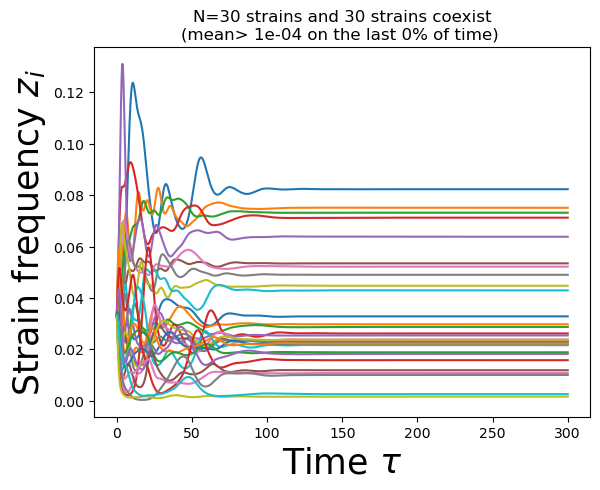

In [19]:
# compute the equilibrium of predicted model
u0 = (1/strain_number)*np.ones(strain_number)
# u0 = z + abs(np.random.rand(strain_number))*0.001
# u0 = u0/sum(u0)

result, ax = plot_dynamics(T = 300, mu = 0.93, A = Iran_alpha, z0 = u0)

mu, A, fit, resultat, nc = simu(T = 300, mu = 0.93, A = Iran_alpha, z0 = u0)
error = np.linalg.norm(resultat.y[:,-1] - Iran_cases)
print(error)